In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 
import torch
import numpy as np
from torch import distributions, nn, optim
import os
import pandas as pd
from datetime import datetime
from torch.utils.data import TensorDataset, DataLoader
from collections import defaultdict
import time

In [6]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
from distribution_v2 import MeanFieldGaussianDistribution, MeanFieldGaussianFactor

## PVI Functions

In [8]:
# Creating clients. Each client has a t_i, model_i, data_i

def create_client(params, data_knwon):
    N = params['N']
    M = params['M']
    K = params['K']

    H = data_knwon['H']
    y = data_knwon['y']

    ## Splitting data
    client_data = []

    # Distribute data H and Y into K clients.
    L = int(N / K)
    for i in range(K):
        client_H = torch.tensor(H[L*i:L*i+L]).double()
        client_y = torch.tensor(y[L*i:L*i+L]).double()
        
        client_data.append({'x': client_H, 'y': client_y})


    # Making t_i -> it is a modelled exponential distribution
    # So, (np1, np2) will help model it to gaussian-ish
    ti = {
            'np1': torch.zeros(M + 1),
            'np2': torch.zeros(M + 1),
        }
    client_ti = []
    for client in range(K):
        client_ti.append(MeanFieldGaussianFactor(nat_params=ti))

    # np1, np2 are 2 natural parameters of Gaussian, which is 
    # actually modelled from the bernoulli likelihood\

    ## Making a model for each client

    return client_data, client_ti


In [9]:
def likelihood_forward(x, theta):
    """
    Returns the model's likelihood p(y | θ, x).
    :param x: Input of shape (*, D).
    :param theta: Parameters of shape (*, D + 1).
    :return: Bernoulli distribution.
    """
    # assert len(x.shape) in [1, 2], "x must be (*, D)."
    # assert len(theta.shape) in [1, 2], "theta must be (*, D)."

    # include bias
    x_ = torch.cat((x, torch.ones(len(x)).to(x).unsqueeze(-1)), dim=1)
    # else (x_ = x)
    # x_ = x

    # if len(theta.shape) == 1:
    #     logits = x_.unsqueeze(-2).matmul(theta.unsqueeze(-1))
    # else:
    #     if len(x.shape) == 1:
    #         x_r = x_.unsqueeze(0).repeat(len(theta), 1)
    #         logits = x_r.unsqueeze(-2).matmul(
    #             theta.unsqueeze(-1)).reshape(-1)
    #     else:
    #         x_r = x_.unsqueeze(0).repeat(len(theta), 1, 1)
    #         theta_r = theta.unsqueeze(1).repeat(1, len(x_), 1)
    #         logits = x_r.unsqueeze(-2).matmul(
    #             theta_r.unsqueeze(-1)).reshape(len(theta), len(x_))

    x_r = x_.unsqueeze(0).repeat(len(theta), 1, 1)
    theta_r = theta.unsqueeze(1).repeat(1, len(x_), 1)
    logits = x_r.unsqueeze(-2).matmul(
        theta_r.unsqueeze(-1)).reshape(len(theta), len(x_))

    return distributions.Bernoulli(logits=logits)

In [10]:
def gradient_based_update(data, p, training_paras,init_q=None):
        # Copy the approximate posterior, make non-trainable.
        q_old = p.non_trainable_copy()
        q_cav = p.non_trainable_copy()

        if init_q is not None:
            q = init_q.trainable_copy()
        else:
            # Initialise to prior.
            q = p.trainable_copy()
            
        ''' Optimizer Part '''
        q_parameters = list(q.parameters())

        parameters = [
            {"params": q_parameters[0]},
            {"params": q_parameters[1]},
        ]


        # Reset optimiser.
        optimiser = torch.optim.Adam(q_parameters, lr=training_paras['lr'])
        lmbda = lambda epoch: training_paras['lambda']
        lr_scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimiser, lr_lambda=lmbda)
        # breakpoint()

        # Set up data
        x = data["x"]
        y = data["y"]
        batch_size = training_paras['batch']
        epochs = training_paras['epochs']

        tensor_dataset = TensorDataset(x, y)
        loader = DataLoader(
            tensor_dataset, batch_size=batch_size, shuffle=True
        )
        epoch_iter = tqdm(
            range(epochs),
            desc="Epoch",
            leave=True,
            disable=True
        )
        # breakpoint()
        for i in epoch_iter:
            for (x_batch, y_batch) in iter(loader):

                optimiser.zero_grad()

                batch = {
                    "x": x_batch,
                    "y": y_batch,
                }

                kl = q.kl_divergence(q_cav).sum() / len(x)

                thetas = q.rsample((1,)).double()
                dist = likelihood_forward(batch["x"], thetas)

                ll = dist.log_prob(batch["y"]).mean()
                ll = ll.sum() / len(x_batch)
                loss = kl - ll
                loss.backward()
                optimiser.step()

            if i > 0:
                lr_scheduler.step()

        
        q_new = q.non_trainable_copy()

        return q_new

In [11]:
def get_t_update(q_new, q_old, t_old):
    # Compute new local contribution from old distributions
    t_new = t_old.compute_refined_factor(
        q_new,
        q_old,
        damping=1,
        valid_dist=False,
        update_log_coeff=True,
    )

    return t_new

In [12]:
def get_nmse_ber(mean_x, x_true):
    mean_x = np.array(mean_x)
    x_true = np.array(x_true)
    norm_diff_squared = np.linalg.norm((x_true - mean_x)**2)
    norm_x_squared = np.linalg.norm(x_true**2)
    NMSE = norm_diff_squared / norm_x_squared
    NMSE_dB = 10 * np.log10(NMSE)

    BER = np.sum(np.sign(mean_x) != np.sign(x_true)) / len(x_true.flatten())

    return NMSE_dB, BER

In [129]:
def get_results(params, client_data, client_ti, training_params, x_true):
    N = params['N']
    M = params['M']
    K = params['K']

    ## Prior same as N(0,1)
    q_params = {
        "loc": torch.zeros(M + 1),
        "scale": torch.ones(M + 1),
    }
    q = MeanFieldGaussianDistribution(std_params=q_params, is_trainable=False)

    
    for i in range(training_params['loops']):
    # for i in range(10):
        q_old = q
        if i == 0:
            init_q = q
        else:
            init_q = None
        for k in range(K):
            # Compute q_k -> it will also have (mean, std) form.
            q_k_new = gradient_based_update(data=client_data[k], p=q, init_q=init_q, training_paras=training_params)
            
            
            # Update approximate likelihood
            # [t_k(i)] = (q_k / q) * [t_k(i-1)]
            t_old = client_ti[k]
            t_k_new = get_t_update(q_k_new, q, t_old)

            # Server update step
            # q update -> q = q * [t_k(i)] / [t_k(i-1)]
            q_updated = q.replace_factor(t_old, t_k_new, is_trainable=False)

            q = q_updated
            client_ti[k] = t_k_new

       
        # NMSE, BER = get_nmse_ber(np.array(q.std_params['loc'][:-1]), x_true)
        
        q_error = np.linalg.norm((q_old.std_params['loc'] - q.std_params['loc'])**2) 
        q_error /= np.linalg.norm((q_old.std_params['loc'])**2)

        # print(f'At iter {i}: q_error = {q_error}, NMSE = {NMSE}')
        
        if q_error <= training_params['stop']:
            break

        
        
    mean_x = np.array(q.std_params['loc'][:-1])

    # NMSE, BER = get_nmse_ber(mean_x, x_true)
    # print(f'At iter {i}: NMSE = {NMSE}', end = ' ')

    return mean_x
            
    

In [130]:
def get_H_error(H_hat, data_unknown): 
    H_hat = np.array(H_hat)
    
    H = data_unknown['H']
    H_error = np.linalg.norm(H - H_hat) / np.linalg.norm(H)
    return H_error

## Generalizing

In [131]:
def generate_data(params, sigma):
    N = params['N']
    M = params['M']
    K = params['K']
    Td = params['Td']
    Tp = params['Tp']
    Tc = Td + Tp

    # X -> Data
    x_true = np.random.choice([-1,1], size=(M,Tc))
    x_true = torch.tensor(x_true).double()
    
    # H -> Channel
    H = np.random.normal(0,1, size=(N,M))
    H = torch.from_numpy(H).double()

    # noise -> Noise
    noise = torch.from_numpy(np.random.normal(0, sigma, size=(N,Tc)))

    R = H @ x_true + noise

    y = (np.sign(R) + 1)/2
    y = torch.tensor(y).double()

    data_known = {
        'x': x_true[:, :Tp],
        'y': y
    }
    data_unknown = {
        'x_true': x_true,
        'H': H,
    }

    return data_known, data_unknown

In [132]:
def get_channel(data_known, params_H, training_params_H, data_unknown):
    N = data_known['x'].shape[1]
    params_H['N'] = N
    cols = params_H['Cols']
    M = params_H['M']
    mean_H = np.zeros((M, cols))
    for col in range(cols):
        data_known_row = {
            'H': data_known['x'].T,
            'y': data_known['y'].T[:, col]
        }

        client_data, client_ti = create_client(params_H, data_known_row)
        mean_H_col = get_results(params_H, client_data, client_ti,training_params_H, data_unknown['H'][col])
        # mean_H[:, col] = mean_H_col
        mean_H[:, col] = (M**0.5) * (mean_H_col / np.linalg.norm(mean_H_col))

        # print('Col #', col, ' done!')

    mean_H = mean_H.T
    data_known['H'] = mean_H

    return mean_H, data_known

In [133]:
def get_data(data_known, params, training_params_x, data_unknown):
    M = params['M']
    Td = params['Td']
    Tp = params['Tp']
    Td = params['Td']
    mean_x = np.zeros((M, Td))
    for col in range(0,Td):
        data_known_row = {
            'H': data_known['H'],
            'y': data_known['y'][:, Tp:][:, col]
        }

        client_data, client_ti = create_client(params, data_known_row)
        mean_x_col = get_results(params, client_data, client_ti, training_params_x, data_unknown['x_true'][:, Tp:][:, col])
        mean_x[:, col] = (M**0.5) * (mean_x_col / np.linalg.norm(mean_x_col))

        # print('Col #', col, ' done!')

    data_known['x'] = np.sign(np.concatenate((data_known['x'][:, :Tp], mean_x), axis=1))

    return mean_x, data_known

## Saving the results

In [134]:
N = 128
M = 20
K = 1
Tp = 80
Td = 200
Tc = 280


params = {
    'N': N,
    'M': M, 
    'K': K,
    'Tp': Tp,
    'Td': Td,
    'Tc': Tc
}

params_H = {
    'N': None,   # Define inside function  = data_known['x'].shape[1]
    'M': M,
    'K': 1,
    'Cols': N
}

training_params_H = {
    'lr': 1e-2,
    'batch': 10000,
    'epochs': 20,
    'loops': 30,
    'lambda': 0.95,
    'stop': 5e-4
}

# training_params_x = {
#     'lr': 1e-2,
#     'batch': 8,
#     'epochs': 10,
#     'loops': 10,
#     'lambda': 0.95,
#     'stop': 1e-3
# }

training_params_x = {
    'lr': 1e-2,
    'batch': 10000,
    'epochs': 20,
    'loops': 10,
    'lambda': 0.95,
    'stop': 1e-3
}

In [135]:
snr_ranges = list(range(-15,11,5))

# snr = -10log(sigma**2)
# sigma_sq = 10**(-snr/10)

sigma_list = []

for snr in snr_ranges:
    sigma_sq = 10**(-snr/10)
    sigma = sigma_sq**0.5
    sigma_list.append(sigma)

sigma_list

[5.623413251903491,
 3.1622776601683795,
 1.7782794100389228,
 1.0,
 0.5623413251903491,
 0.31622776601683794]

In [136]:
def create_snr_files():
    """Create CSV files for each SNR value if they don't exist"""
    os.makedirs('data', exist_ok=True)
    
    # Define base columns
    columns = ['timestamp', 'snr', 'sigma', 'nmse', 'ber']
    # Create a file for each SNR if it doesn't exist
    for snr in snr_ranges:
        file_path = f'data/results_snr_{snr}dB.csv'
        if not os.path.exists(file_path):
            df = pd.DataFrame(columns=columns)
            df.to_csv(file_path, index=False)
            print(f"Created file: {file_path}")

create_snr_files()

In [139]:
NMSE_dict = {}
BER_dict = {}
for runs in range(5):
    for sigma_i in range(len(snr_ranges)):
        K = 1
        NMSE_list = []
        BER_list = []
        for _ in range(K):
            data_known, data_unknown = generate_data(params, sigma_list[sigma_i])
            H_error_list = []
            for i in range(4):
                print(f'##### SNR = {snr_ranges[sigma_i]}dB ##### Example {_ + 1} #####')
                mean_H, data_known = get_channel(data_known, params_H, training_params_H, data_unknown)
                if i > 0:
                    H_change = get_H_error(mean_H, {'H': H_error_list[-1]})
                    print(f'Iter #{i}: H-change = {H_change}')
                else:
                    H_change = 1
                    print(f'Iter #{i}: H-change = NA')

                # print('H-actual-error: ', get_H_error(mean_H, data_unknown))
                print(get_H_error(data_known['H'], data_unknown), get_nmse_ber(data_known['H'], data_unknown['H']))

                # data_known['H'] = data_unknown['H']

                mean_x, data_known = get_data(data_known, params, training_params_x, data_unknown)

                NMSE, BER = get_nmse_ber(mean_x,  data_unknown['x_true'][:, Tp:])
                print(f'Iter #{i}: NMSE = {NMSE}dB, BER = {BER}')

                if H_change < 0.3:
                    break
                H_error_list.append(H_change)

            NMSE_list.append(NMSE)
            BER_list.append(BER)

            file_path = f'data/results_snr_{snr_ranges[sigma_i]}dB.csv'

            new_row = {
                'timestamp': datetime.now(),
                'snr': snr_ranges[sigma_i],
                'sigma': sigma_list[sigma_i],
                'nmse': NMSE,
                'ber': BER,
            }

            # Check if the file exists, if not create it with headers
            try:
                df = pd.read_csv(file_path)
            except FileNotFoundError:
                df = pd.DataFrame(columns=new_row.keys())

            # Append new row and save
            df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)
            df.to_csv(file_path, index=False)

        NMSE_dict[snr_ranges[sigma_i]] = sum(NMSE_list)/K
        BER_dict[snr_ranges[sigma_i]] = sum(BER_list)/K
    
    print('Run #', runs, ' done!')
        # time.sleep(5)
    # time.sleep(40)


##### SNR = -15dB ##### Example 1 #####


In [ ]:
np.linalg.norm(data_known['H'] - data_unknown['H']) / np.linalg.norm(data_unknown['H'])

In [50]:
get_H_error(data_known['H'], data_unknown), get_nmse_ber(data_known['H'], data_unknown['H'])

(0.4478299335855102, (-6.960112064407369, 0.13671875))

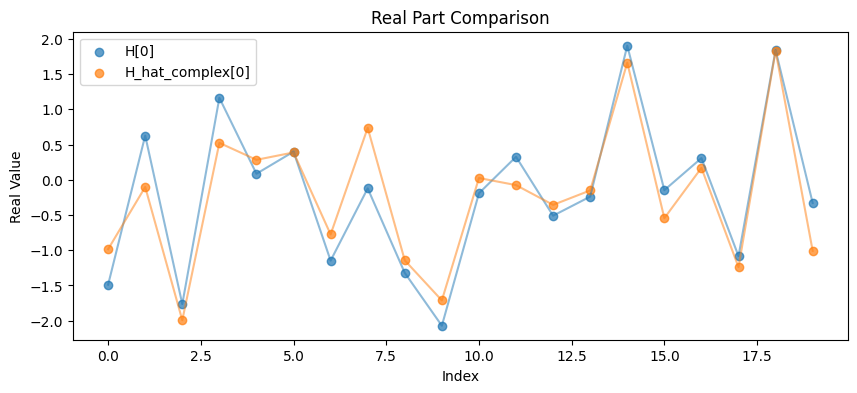

In [51]:
def plot_H_hat(H_hat_complex, data_unknown):
    H = data_unknown['H']

    plt.figure(figsize=(10, 4))

    # Plotting the real part
    plt.title('Real Part Comparison')
    plt.scatter(range(len(np.real(H[0]))), np.real(H[0]), label='H[0]', alpha=0.7)
    plt.plot(range(len(np.real(H[0]))), np.real(H[0]), alpha=0.5)  # Line for H[0]
    plt.scatter(range(len(np.real(H_hat_complex[0]))), np.real(H_hat_complex[0]), label='H_hat_complex[0]', alpha=0.7)
    plt.plot(range(len(np.real(H_hat_complex[0]))), np.real(H_hat_complex[0]), alpha=0.5)  # Line for H_hat_complex[0]
    plt.xlabel('Index')
    plt.ylabel('Real Value')
    plt.legend()

plot_H_hat(data_known['H'], data_unknown)